In [1]:
import os, tqdm, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import sys
sys.path.append('../')

import time
from tqdm import tqdm

from ptype.soundings import utils

In [2]:
df = pd.read_hdf('/glade/scratch/dkimpara/ptype_data/df_evidential.h5', key='df')  
df_det = pd.read_hdf('/glade/scratch/dkimpara/ptype_data/df_det.h5', key='df_det')  

# Plotting Code

In [3]:
PROFILE_VAR='TEMP_C'

In [4]:
def extract_cols(df, plot_var='TEMP_C'):
    #convert column headers to ints
    all_cols = list(df.columns)
    data_cols = []
    for col in all_cols:
        if plot_var in col: data_cols.append(col)
    
    rename_cols_dict = {col: int(re.findall("(\d+)",col)[0]) for col in data_cols}
    df = df.rename(rename_cols_dict, axis=1)
    
    data_cols_renamed = list(rename_cols_dict.values())
    
    data_cols_renamed = np.array(data_cols_renamed, dtype=int)
    drop_cols = data_cols_renamed[data_cols_renamed > 5100]
    df = df.drop(drop_cols, axis=1)
    
    return df, data_cols_renamed[data_cols_renamed < 5100]

ptype_dict = {0: 'Rain',
      1: 'Snow',
      2: 'Sleet',
      3: 'Frz Rain'}

color_dict = {0: 'm',
              1: 'b',
              2: 'y',
              3: 'c'}

color_to_ptype = {color: ptype_dict[num] for num, color in color_dict.items()}

def plot_(ax, df, conf, title='', ptypes=range(4), profile_var=PROFILE_VAR, plot_kwargs={}):
    #plot all ptypes on same graph
    for ptype in ptypes:
        subdf = df[(df[f'pred_conf{ptype+1}'] >= conf)]

        subdf, plot_cols = extract_cols(subdf)
        plot_data = subdf[plot_cols]
        profile = plot_data.mean()
        heights = plot_data.columns

        (line,) = ax.plot(profile, heights, color_dict[ptype], linewidth=2, **plot_kwargs)
        
        line.set_label(
            (
                f'{ptype_dict[ptype]}'
            )
        )
    ax.set_xlabel(f'{profile_var}')
    ax.set_title(title)
    return ax

# top 10% left
# bottom 10% right
# top 10 probability plots

In [5]:
def plot_many_conf(ax, df, levels, ptypes=range(4), title='', profile_var=PROFILE_VAR):
    for level in levels:
        alpha = (level - min(levels)) / (max(levels) - min(levels)) * 0.9 + 0.1
        ax = plot_(ax, df, level, ptypes=ptypes, plot_kwargs={'alpha':alpha},
                        title=title, profile_var=profile_var)
    return ax

## plot by confidence

<SkewXAxes: xlabel='TEMP_C', ylabel='Height above ground (m)'>

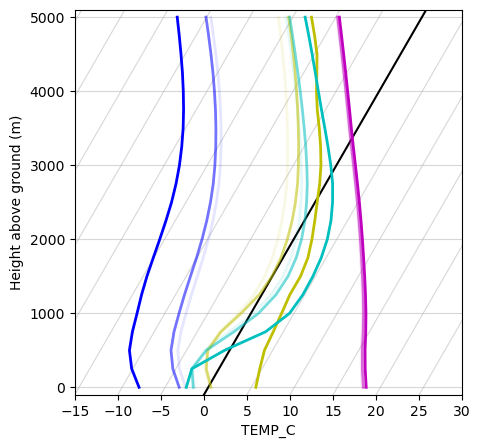

In [6]:
fig, axs = utils.skewCompositeFigAx(figsize=(5, 5), num_subplots=1)

plot_many_conf(axs[0], df, [0.5,0.7,0.9])

# sleet:

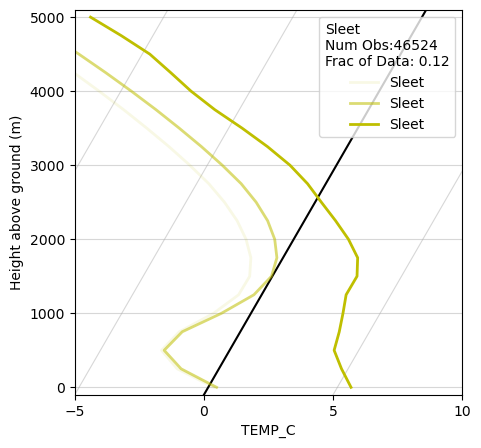

In [7]:
fig, axs = utils.skewCompositeFigAx(figsize=(5, 5), num_subplots=1)

ax = plot_many_conf(axs[0], df, [0.5,0.7,0.9], ptypes=[2])

ax.set_xlim(-5,10)
num_sleet = (df.pred_label == 2).sum()
num_total = df.shape[0]

ax.legend(title=f'Sleet\nNum Obs:{num_sleet}\nFrac of Data: {num_sleet/num_total:.2f}')

# investigating types of sleet soundings

## preprocess and write data

# extract bad soundings
def contiguous_chunks(data):
    return np.split(data, np.where(np.diff(data) != 0)[0]+1)

def num_zero_crossings(row):
    abv_zero = (row >= 0.0)
    chunks = contiguous_chunks(abv_zero)
    return len(chunks) - 1

def cross_below_h(row, height=1000):
    # did the sounding go positive below height m
    abv_zero = (row >= 0.0)
    chunks = contiguous_chunks(abv_zero)
    first_chunk = chunks[0]
    
    if (first_chunk.index.max() < height) and (np.all(first_chunk)):
        #first chunk is all above 0
        return 1
    else:
        return 0
    


sleetdf = df[(df.pred_label == 2) | (df.true_label == 2) | (df.CICEP == 1)].copy()
sleetdf, temp_cols = extract_cols(sleetdf)

sleetdf['num_crossings_zero'] = sleetdf.apply(lambda row: num_zero_crossings(row[temp_cols]), axis=1)
#for height in tqdm(list(np.arange(1000,2500,250)) + [3000]):
for height in tqdm([1000, 3000]):
    sleetdf[f'cross_below_{height}'] = sleetdf.apply(lambda row: cross_below_h(row[temp_cols], height), axis=1)

sleetdf.to_hdf('/glade/scratch/dkimpara/ptype_data/sleet_processed.h5', 'sleetdf')

# plot

In [37]:
def plot_mean_med_density(ax, subdf, quantiles=[0, 0.1, 0.3, 0.5]):
    mean = subdf.mean()
    num_obs = subdf.shape[0]
    ax.plot(mean, mean.index, color = 'tab:orange')
    ax.plot([],[], color='tab:orange')[0].set_label('mean')
    ax.plot([],[], color='b')[0].set_label('median')

    
    for q in quantiles:
        ax.fill_betweenx(np.array(subdf.columns, dtype=int), 
                         subdf.quantile(q), 
                         subdf.quantile(1-q), 
                         alpha=0.2, color='b')
        
    ax.legend(title=(
                     f"density for sleet\nNum Obs: {num_obs}\n"
                     f"Frac of All Sleet: {num_obs/NUM_SLEET:.2f}\n"
                     f"Frac of {PRED}: {num_obs/NUM_PRED:.2f}"

                    ))

## load and select data to plot

In [62]:
sleetdf = pd.read_hdf('/glade/scratch/dkimpara/ptype_data/sleet_processed.h5', 'sleetdf')  
temp_cols = [col_name for col_name in list(sleetdf.columns) if isinstance(col_name, int)]

NUM_SLEET = sleetdf.shape[0]

#PRED = 'pred_label'
PRED = 'true_label'
#PRED = 'CICEP'

if PRED == 'CICEP': 
    sleetdf = sleetdf[sleetdf['CICEP'] == 1]
else: 
    sleetdf = sleetdf[sleetdf[PRED] == 2]
NUM_PRED = sleetdf.shape[0]
sleetdf = sleetdf[(sleetdf['CICEP'] == 1)]


# no filter

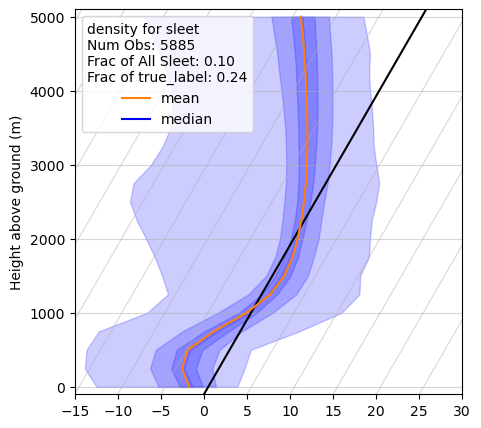

In [63]:
subdf = sleetdf

fig, axs = utils.skewCompositeFigAx(figsize=(5, 5), num_subplots=1)
ax = axs[0]
plot_mean_med_density(ax, subdf[temp_cols])

# zero crossings


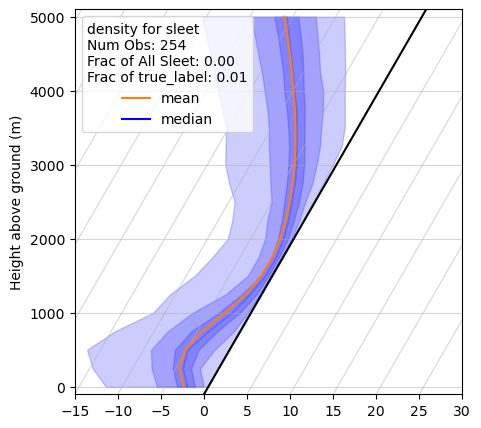

In [64]:
subdf = sleetdf[(sleetdf.num_crossings_zero == 0)]


fig, axs = utils.skewCompositeFigAx(figsize=(5, 5), num_subplots=1)
ax = axs[0]
plot_mean_med_density(ax, subdf[temp_cols])

# one crossing

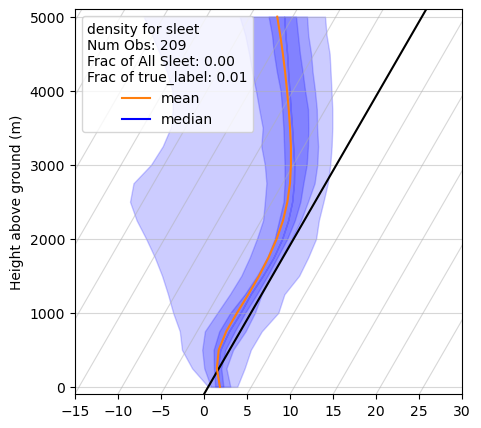

In [65]:
subdf = sleetdf[(sleetdf.num_crossings_zero == 1)]

fig, axs = utils.skewCompositeFigAx(figsize=(5, 5), num_subplots=1)
ax = axs[0]
plot_mean_med_density(ax, subdf[temp_cols])

## crossing is below 1000m

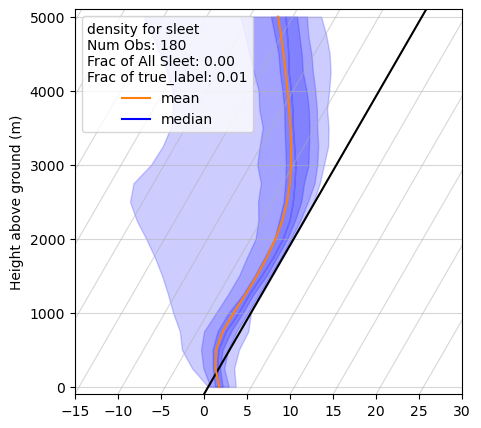

In [66]:
subdf = sleetdf[(sleetdf.num_crossings_zero == 1) & (sleetdf.cross_below_1000 == 1)]

fig, axs = utils.skewCompositeFigAx(figsize=(5, 5), num_subplots=1)
ax = axs[0]
plot_mean_med_density(ax, subdf[temp_cols])

## crossing is below 3000m

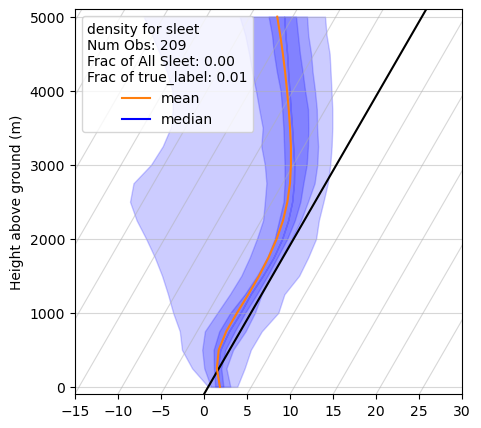

In [67]:
subdf = sleetdf[(sleetdf.num_crossings_zero == 1) & (sleetdf.cross_below_3000 == 1)]

fig, axs = utils.skewCompositeFigAx(figsize=(5, 5), num_subplots=1)
ax = axs[0]
plot_mean_med_density(ax, subdf[temp_cols])

## crossing is above 1000m

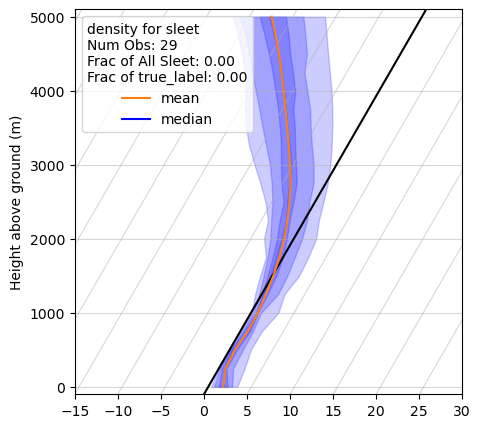

In [68]:
subdf = sleetdf[(sleetdf.num_crossings_zero == 1) & (sleetdf.cross_below_1000 == 0)]

fig, axs = utils.skewCompositeFigAx(figsize=(5, 5), num_subplots=1)
ax = axs[0]
plot_mean_med_density(ax, subdf[temp_cols])

## two crossings or more

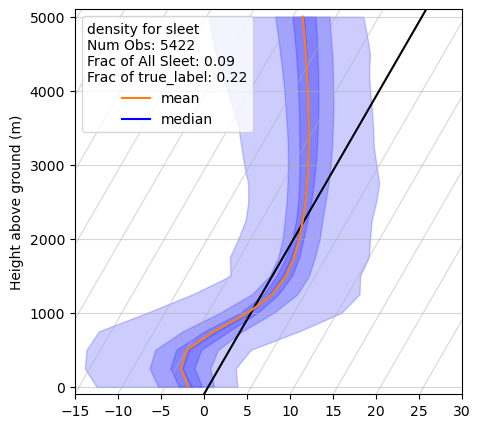

In [69]:
subdf = sleetdf[(sleetdf.num_crossings_zero >= 2)]

fig, axs = utils.skewCompositeFigAx(figsize=(5, 5), num_subplots=1)
ax = axs[0]
plot_mean_med_density(ax, subdf[temp_cols])